In [1]:
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the Data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

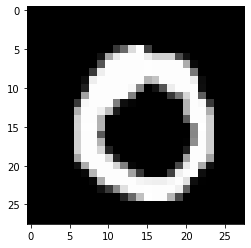

In [3]:
# Plot a random Image
plt.imshow(train_images[56], cmap='gray')

In [4]:
# Make Rank-4 Tensors as cast the dtype to 'float32'
print(f"Shape before reshaping: {train_images.shape}")
train_images = train_images.reshape(
    train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(
    test_images.shape[0], 28, 28, 1).astype('float32')
print(f"Shape after reshaping: {train_images.shape}")

Shape before reshaping: (60000, 28, 28)
Shape after reshaping: (60000, 28, 28, 1)


In [5]:
# Normalize the images
train_images = train_images / 255
test_images = test_images / 255

In [6]:
# Convert labels to one-hot vectors
print(f"Labels shape before: {train_labels.shape}")
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print(f"Labels shape after one-hot: {train_labels.shape}")

Labels shape before: (60000,)
Labels shape after one-hot: (60000, 10)


In [7]:
# Define CNN Architecture
def baseline_Model(input_shape):

    # Get Sequential Model
    model = Sequential()

    # 1st Convolutional Block
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(5, 5),
                     padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Convolutional Block
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     padding='Same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Classification Block
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    # Define the optimizer
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

    # Compile the Model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                patience=3,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)

    # Model Checkpoints
    filepath = "./checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    # Make a callbacks list
    callbacks_list = [learning_rate_reduction, checkpoint]

    return model, callbacks_list

In [8]:
# Metadata
input_shape = train_images.shape[1:]
epochs = 30
batch_size = 86

In [9]:
# Get the model and learning_rate_reduction
model, callbacks_list = baseline_Model(input_shape)

In [10]:
# See the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [11]:
# Fit the Model
history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=batch_size,
    epochs=epochs,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=(test_images, test_labels),
    steps_per_epoch=train_images.shape[0] // batch_size,
    use_multiprocessing=True,
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
59942/60000 [============================>.] - ETA: 0s - loss: 0.1594 - accuracy: 0.9490
Epoch 00001: val_accuracy improved from -inf to 0.98720, saving model to ./checkpoints/weights-improvement-01-0.99.hdf5
59914/60000 [============================>.] - ETA: 0s - loss: 0.0527 - accuracy: 0.9832
Epoch 00002: val_accuracy improved from 0.98720 to 0.99280, saving model to ./checkpoints/weights-improvement-02-0.99.hdf5
59914/60000 [============================>.] - ETA: 0s - loss: 0.0398 - accuracy: 0.9877
Epoch 00003: val_accuracy did not improve from 0.99280
59914/60000 [============================>.] - ETA: 0s - loss: 0.0333 - accuracy: 0.9898
Epoch 00004: val_accuracy did not improve from 0.99280
59914/60000 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9911
Epoch 00005: val_accuracy improved from 0.99280 to 0.99310, saving model to ./checkpoints/weights-improvement-05-0.99.hdf5
59914/60000 [=====

59914/60000 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9986
Epoch 00026: val_accuracy did not improve from 0.99600
59914/60000 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9986
Epoch 00027: val_accuracy did not improve from 0.99600
59914/60000 [============================>.] - ETA: 0s - loss: 0.0049 - accuracy: 0.9986
Epoch 00028: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00028: val_accuracy did not improve from 0.99600
59914/60000 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9987
Epoch 00029: val_accuracy did not improve from 0.99600
59914/60000 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9985
Epoch 00030: val_accuracy did not improve from 0.99600
59914/60000 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9985 - val_loss: 0.0167 - val_accuracy: 0.9956

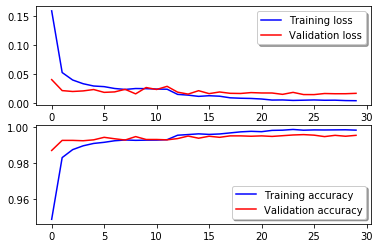

In [13]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r',
           label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'],
           color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Visualization

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models

In [2]:
# Load the data set
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Shape of the tensor is: (1, 28, 28, 1)


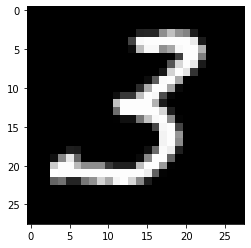

In [3]:
# Cast the numpy array to list
train_images = list(train_images)

# Chose a random image
random_image = random.choice(train_images)

# Plot the image
plt.imshow(random_image, cmap='gray')

# Process the image and make a tensor Rank 4 Tensor
random_image = np.expand_dims(random_image, axis=0)
random_image = np.expand_dims(random_image, axis=3)

# Normalize the tensor
random_image = random_image / 255

print(f"Shape of the tensor is: {random_image.shape}")

In [4]:
# Load the model
model = load_model("./checkpoints/weights-improvement-25-1.00.hdf5")

In [5]:
# Get the layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Create an Activation Model
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [6]:
# Generate Activations
activations = activation_model.predict(random_image)

/home/ibtihaj/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


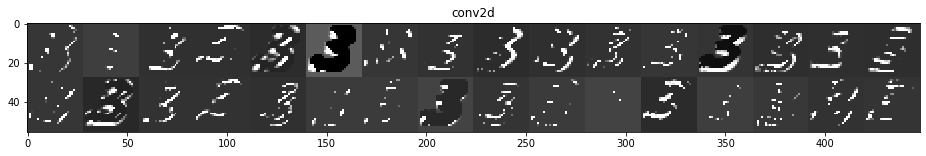

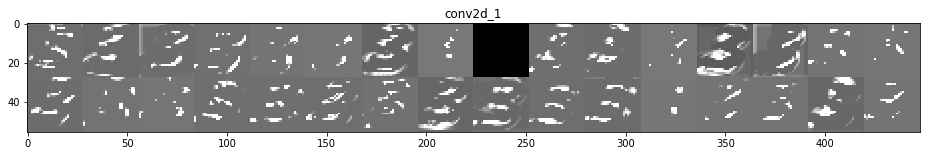

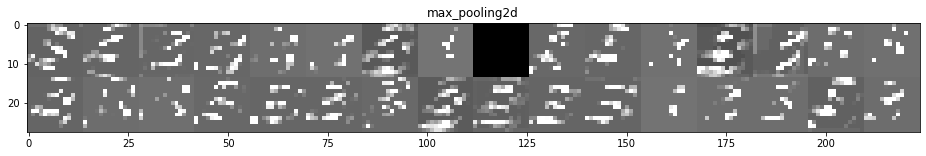

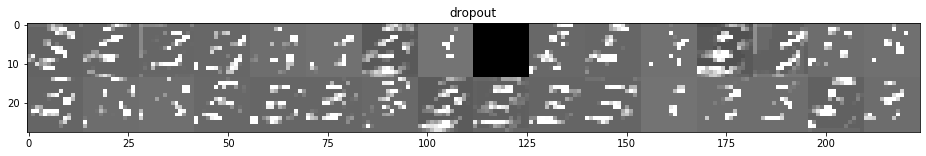

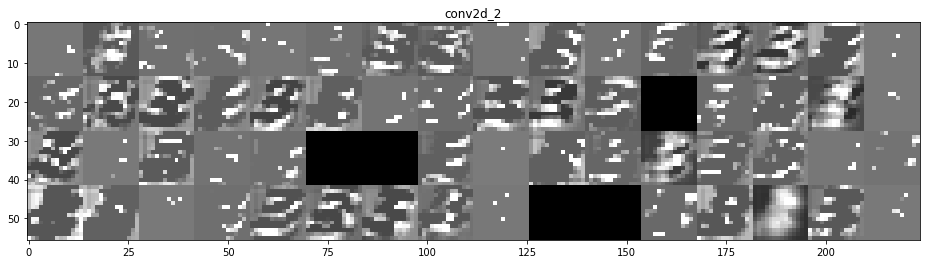

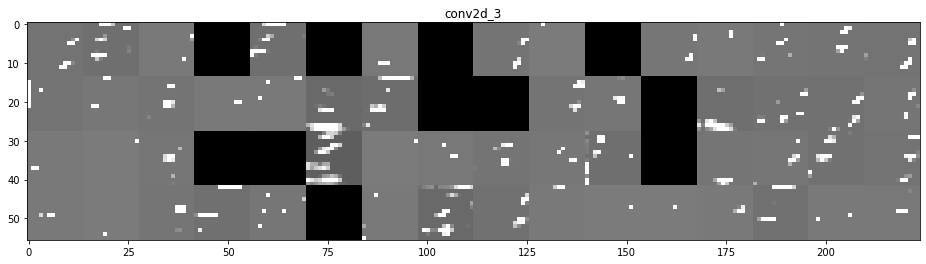

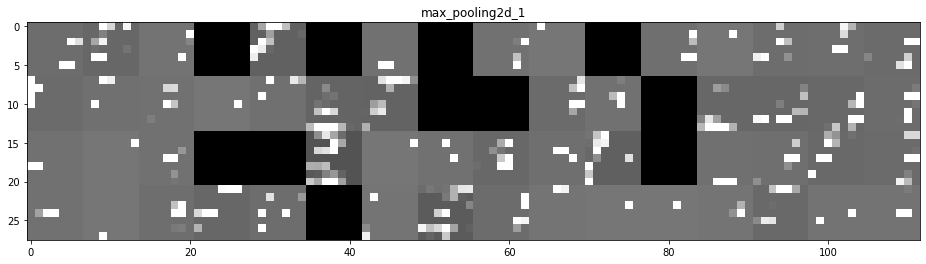

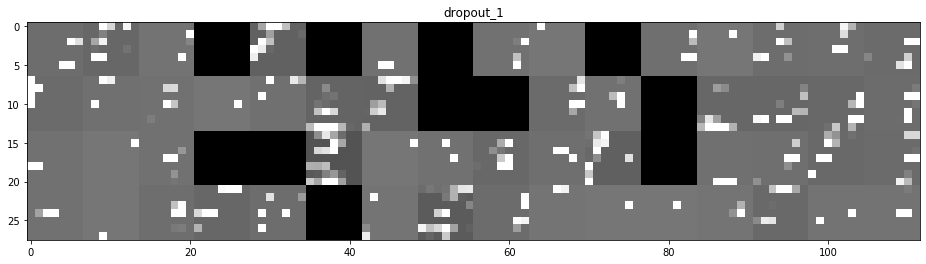

In [7]:
# Get layer names
layer_names = [layer.name for layer in model.layers[:8]]

# How many feature maps per row
images_per_row = 16

# Displays the feature maps
for layer_name, layer_activation in zip(layer_names, activations):

    # Number of kernels per layer
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features).
    size = layer_activation.shape[1]

    # Tiles the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):  # Tiles each kernel into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :, col * images_per_row + row]
            # Post-processes the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col + 1) * size,  # Displays the grid
                         row * size: (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')